# What is wrong with the below news item?


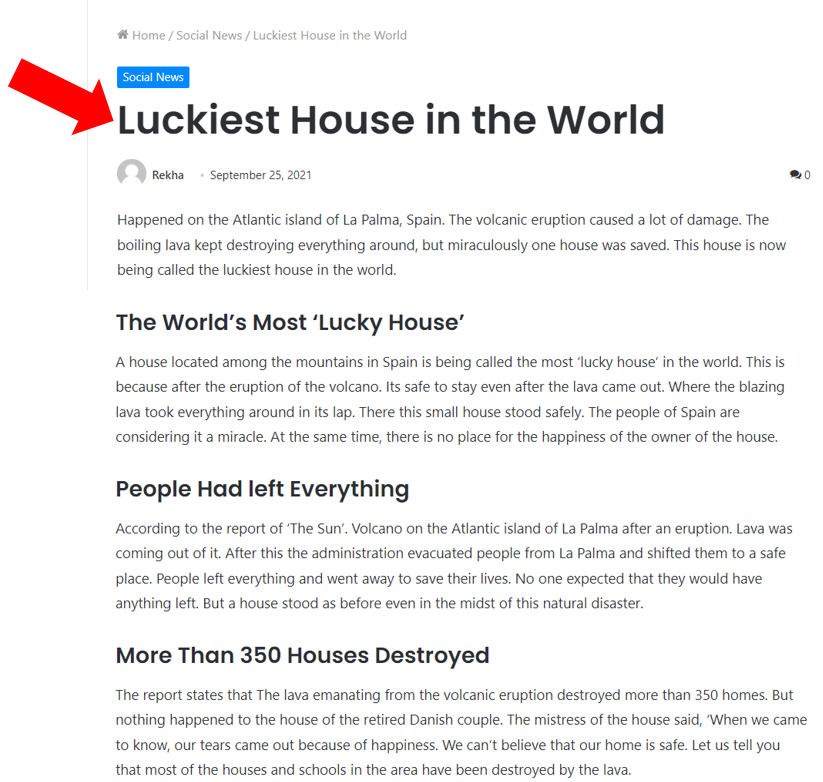


At first glance, it seems to be a completly harmless piece of news with an attractive headline except for the fact that it unncessarily uses a superlative without justifying its claim in the body that follows. Consider the words "this is luckiest house in the world", there is no justification, quatification or explanation for that claim anywhere in the 4 paragraphs that constitute the body of the news item. Clearly, the headline is an exaggerated one meant to serve as a clickbait!

On some further research across a few other news websites, I found few more such examples. For example, consider these:

*Prince Philip: the world’s luckiest man, yet he seethed with anger!*

*The 27 Best Ways to Train a Dog!*

This is just the tip of the iceberg when it comes to exaggerated and misleading headlines online. However, the specific problem of unnecessary/misleading use of superlatives in news headlines is even more rampant in the Hindi language (one the most widely spoken languages in india). Consider these examples⁉

*ये हैं दुनिया के सबसे खतरनाक द्वीप, जहां जाकर आप देंगे 'मौत को दावत'!*

*सर्दियों में होने वाली शादियों में इन पांच तरीकों को अपनाकर दिखेंगी सबसे 'स्टाइलिश'!*

*फेफड़े का कैंसर फैलने की सबसे बड़ी वजह बना वायु प्रदूषण!*

In all the above news headlines, the superlatives are neither justified through proper quantification nor they are supported or even mentioned again (proving they were just used to mislead), in their corresponding bodies.

Some justified use of superlatives in news headlines are given below:

***पीएम मोदी ने विश्‍व की सबसे लंबी सुरंग की राष्ट्र को समर्पित***

*प्रधानमंत्री नरेंद्र मोदी ने हिमाचल प्रदेश के रोहतांग में विश्‍व की सबसे लंबी अटल सुरंग का उद्घाटन किया। 9.02 किलोमीटर की इस टनल के शुरु होने से मनाली और लेह के बीच सड़क की दूरी 46 किलोमीटर कम हो जाएगी। समुद्र तल से 10 हजार फुट की ऊंचाई पर अत्याधुनिक तकनीक और इलेक्टो-मैक्निकल प्रणाली से इसका निर्माण किया गया है।*


***चंद्रग्रहण लगा, 580 साल में सबसे लंबी अवधि का ग्रहण***

*स्पेस डॉट कॉम के मुताबिक इस चंद्र ग्रहण की अवधि सबसे ज़्यादा ध्यान खींचने वाली है. चंद्र ग्रहण तीन घंटे, 28 मिनट और 24 सैकेंड तक रहेगा और यह 580 सालों में सबसे लंबा आंशिक ग्रहण बन जाएगा.*

As a result of this observation, I wanted to explore the possibility of Deep Learning models (especially Recurrent Neural Networks for Natural Language Processing use cases) to identify such misleading headlines and highlight them to the readers to enable them make an informed choice. The rest of the notebook describes the exploration of various techniques to solve this problem with a demo of the model being used on some real-life news articles at the end.

# Data collection technique

I present this use case as a binary classification problem. As I am dealing with a vernacular language here, there is no labelled dataset that is already available. I, therefore, scraped some popular and not-so popular online news websites for data. This was followed by going through each headline-body pair of news items and labelling them as "misleading (1)" or "accurate (0)". I created a python app that recursively scrapes websites and presents the user with a headline-body pair on the screen and asks whether the pair is accurate or misleadingly uses superlatives. This sped up the process a little bit!

An indicative snippet of the code is given below (it may not work as expected in colab, run it as a desktop app). it saves the output as an excel file as per user inputs as shown below:

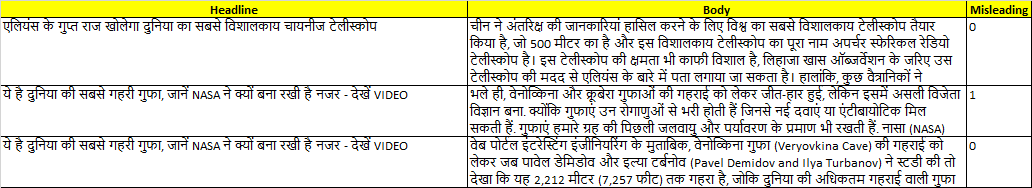

Web scraping code: https://github.com/utsavdatta-git/Identifying-Misleading-Superlatives-in-News/tree/main/NewsScraper

# Package installations

In [33]:
! pip install fasttext
! pip install pdpipe
! pip install transformers
! pip install sentencepiece

# Some basic package imports

In [2]:
import pandas as pd
import fasttext
import fasttext.util
import tensorflow as tf
from tensorflow import keras
import numpy as np
import re
import string
import pdpipe as pdp
from keras.utils.vis_utils import plot_model
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import pickle
from transformers import TFAutoModel, AutoTokenizer, BertModel, BertTokenizer
from joblib import dump, load
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Reading the news headline and body data, shuffling them and splitting them up into train and test sets

In [2]:
# Read train data
news_dataset_full = pd.read_excel("/content/drive/MyDrive/Datasets/news_dataset.xlsx", sheet_name="Train")
print(f"Dataset shape: {news_dataset_full.shape}")
# Shuffle the dataframe
news_dataset_full = news_dataset_full.sample(frac=1).reset_index(drop=True)
news_dataset_full.head()

Dataset shape: (751, 3)


,Headline,Body,Misleading
0,"Anti Obesity Day: डायबिटीज से लेकर कैंसर तक, म...",टाइप 2 डायबिटीज (Type 2 Diabetes)- टाइप 2 डायब...,1
1,देश की सबसे खतरनाक मिसाइल ब्रह्मोस का हुआ सफल ...,देश ने सुपरसोनिक क्रूज मिसाइल ब्रह्मोस के लैंड...,1
2,ओलंपिक में सबसे ज्यादा मेडल जीतने वाले “गोल्डन...,माइकल फेल्प्स का नाम ओलंपिक में सबसे ज्यादा मे...,0
3,सर्दियों में होने वाली शादियों में इन पांच तरी...,अलग-अलग मौसम में होने वाली शादियों के अपने ही ...,1
4,"अमेरिका के सबसे लंबे सैन्य अभियान का अंत, अफ़ग...",इस संबंध में जानकारी देते हुए बताया गया है कि ...,1


In [3]:
# Performing train test split
from sklearn.model_selection import train_test_split
y = news_dataset_full.pop("Misleading")
news_dataset_train, news_dataset_test, y_train, y_test = train_test_split(news_dataset_full, y, test_size=0.2, random_state=42)

In [4]:
print(news_dataset_test.head())
print(news_dataset_test.shape)

                                              Headline                                               Body
473  विश्व का सबसे बड़ा मंदिर पश्चिम बंगाल में, जल्...  नई दिल्ली (विशेष): दुनिया का सबसे बड़ा मंदिर इ...
357  दुनिया का सबसे तेज उड़ने वाला इलेक्ट्रिक प्‍ले...  इस विमान ने ताजा टेस्‍ट में करीब 3 किमी की दूर...
133   \n        देश के सबसे लोकप्रिय यूट्यूबर भुवन बाम  यूट्यूबर, अभिनेता और इनफ्लुएंसर भुवन बाम वर्तम...
250  पीएम मोदी ने विश्‍व की सबसे लंबी सुरंग की राष्...  प्रधानमंत्री नरेंद्र मोदी ने हिमाचल प्रदेश के ...
299  धरती की ओर आ रहा महाविशाल धूमकेतु, अब तक का सब...  सिल्‍वेनिया: सौर मंडल (Solar System) में धरती ...
(151, 2)


In [5]:
print(news_dataset_train.head())
print(news_dataset_train.shape)

                                              Headline                                               Body
131  दुनिया के सबसे खतरनाक भूकंप, जब मिनटों में चली...  शिमल, तीसा, जागरण टीम। Earthquake In Chamba, च...
44   Chandra Grahan 2021: 19 नवंबर को लगेगा सदी का ...  ज्योतिष शास्त्र के मुताबिक, चंद्रग्रहण का असर ...
70   ये हैं दुनिया का एक सबसे बड़ा जंगल, जान लीजिये ...  वैज्ञानिकों ने 1 इंच से भी छोटा गिरगिट खोजा है...
673  ईरान की नौसेना का सबसे बड़ा जहाज़ डूबा, इसराइल...  तस्नीम न्यूज़ एजेंसी पर जारी बयान में कहा गया ...
208  पिछले दो सालों में अहान शेट्टी ने किया सबसे सफ...  नई दिल्ली, जेएनएन। बॉलीवुड के एक्शन एक्टर सुनी...
(600, 2)


# Data Preprocessing:
1. Remove leading and trailing spaces
2. Replace numbers with a special word (संख्या) that will represent all  numbers, as numbers hold special importance in this task (may not be useful)
3. Replace % sign with प्रतिशत (a word representation of the symbol) (may not be useful)
4. Remove all English words
5. Remove punctuations
6. Remove some special characters
7. Remove extra spaces within sentences
8. Remove some basic stop words

In [12]:
def remove_leading_trailing_spaces(x):
  return x.strip()

def remove_line_feeds(x):
  x = x.replace("\r", "")
  return x.replace("\n", "")  

def replace_numbers(x):
  return re.sub(r'[0-9]+', ' संख्या ', x)

def replace_percent(x):
  return x.replace('%', ' प्रतिशत ')

def remove_english_words(x):
  return re.sub(r'[a-zA-Z]+', '', x)

def remove_punctuations(x):
  return re.sub('[%s]' % re.escape(string.punctuation), '' , x)

def remove_string_numbers(x):
  return re.sub('W*dw*', '', x)

def remove_numbers(x):
  return re.sub('[0-9]', '', x)

def remove_unwanted_chars(x):
  x = x.replace("–", "").replace(":", "").replace('।', '').replace("’", "").replace("‘", "")
  return x

def remove_extra_spaces(x):
  return re.sub(' +', ' ', x)   

def remove_stopwords(x):
  stopwords_list = ["अत", "अपना", "अपनी", "अपने", "अभी", "अंदर", "आदि", "आप", "इत्यादि", "इन ", "इनका", "इन्हीं", "इन्हें", "इन्हों", "इस", 
  "इसका", "इसकी", "इसके", "इसमें", "इसी", "इसे", "उन", "उनका", "उनकी", "उनके", "उनको", "उन्हीं", "उन्हें", "उन्हों", "उस", "उसके", "उसी", 
  "उसे", "एवं", "एस", "ऐसे", "और", "कर", "करता", "करते", "करना", "करने", "करें", "कहते", "कहा", "का", "कि", "किन्हें", "किन्हों", "किया", "किर", 
  "किस", "किसी", "किसे", "की", "के", "को", "कोई", "कौन", "कौनसा", "गया", "घर", "जब", "जहाँ", "जा", "जिन", "जिन्हें", "जिन्हों", "जिस", "जिसे", 
  "जीधर", "जैसा", "जैसे", "जो", "तक", "तब", "तरह", "तिन्हें", "तिन्हों", "तिसे", "तो", "था", "थी", "थे", "दिया", "द्वारा", "न", "नके", "ना", "ने", 
  "पर", "पूरा", "पे", "फिर", "बनी", "बही", "बाद", "बाला", "भी", "मे", "में", "यदि", "यह", "यहाँ", "यही", "या", "यिह", "ये", "रखें", "रहा", "रहे", "लिए", 
  "लिये", "व", "वर्ग", "वह", "वहाँ", "वहीं", "वाले", "वुह", "वे", "साभ", "से", "सो", "संग", "ही", "हुआ", "हुई", "हुए", "है", "हैं", "हो", "होता", "होती", 
  "होते", "होना", "होने", "लें"]   
  return ' '.join("" if i in stopwords_list else i for i in x.split()) 

def text_preprocessing(data):
  pipeline = pdp.ApplyByCols("Headline", remove_english_words)
  pipeline += pdp.ApplyByCols("Headline", remove_line_feeds)
  #pipeline += pdp.ApplyByCols("Headline", replace_numbers)
  #pipeline += pdp.ApplyByCols("Headline", replace_percent)
  pipeline += pdp.ApplyByCols("Headline", remove_punctuations)
  pipeline += pdp.ApplyByCols('Headline', remove_string_numbers)
  pipeline += pdp.ApplyByCols('Headline', remove_numbers)
  pipeline += pdp.ApplyByCols('Headline', remove_unwanted_chars)
  pipeline += pdp.ApplyByCols('Headline', remove_stopwords)
  pipeline += pdp.ApplyByCols('Headline', remove_extra_spaces)
  pipeline += pdp.ApplyByCols("Headline", remove_leading_trailing_spaces)

  pipeline += pdp.ApplyByCols("Body", remove_english_words)
  pipeline += pdp.ApplyByCols("Body", remove_line_feeds)
  #pipeline += pdp.ApplyByCols("Body", replace_numbers)
  #pipeline += pdp.ApplyByCols("Body", replace_percent)
  pipeline += pdp.ApplyByCols("Body", remove_punctuations)
  pipeline += pdp.ApplyByCols('Body', remove_string_numbers)
  pipeline += pdp.ApplyByCols('Body', remove_numbers)
  pipeline += pdp.ApplyByCols('Body', remove_unwanted_chars)
  pipeline += pdp.ApplyByCols('Body', remove_extra_spaces)
  pipeline += pdp.ApplyByCols('Body', remove_stopwords)
  pipeline += pdp.ApplyByCols('Body', remove_extra_spaces)
  pipeline += pdp.ApplyByCols("Body", remove_leading_trailing_spaces)

  data = pipeline(data)
  
  return data

In [7]:
# Performing data pre processing using the above mentioned steps on both train and test data. These steps will also be used to clean any new data for future predictions
news_dataset_train_cleaned = text_preprocessing(news_dataset_train)
news_dataset_test_cleaned = text_preprocessing(news_dataset_test)

In [8]:
news_dataset_train_cleaned.head()

,Headline,Body
131,दुनिया सबसे खतरनाक भूकंप मिनटों चली गई लाखों ज...,शिमल तीसा जागरण टीम चंबा भूकंप झटके महसूस किए ...
44,नवंबर लगेगा सदी सबसे लंबा चंद्र ग्रहण जानें कि...,ज्योतिष शास्त्र मुताबिक चंद्रग्रहण असर वृषभ रा...
70,दुनिया एक सबसे बड़ा जंगल जान लीजिये खासियत,वैज्ञानिकों इंच छोटा गिरगिट खोजा दुनिया सबसे छ...
673,ईरान नौसेना सबसे बड़ा जहाज़ डूबा इसराइल साथ क्...,तस्नीम न्यूज़ एजेंसी जारी बयान जहाज़ कुछ दिन प...
208,पिछले दो सालों अहान शेट्टी सबसे सफल स्टार किड ...,नई दिल्ली जेएनएन बॉलीवुड एक्शन एक्टर सुनील शेट...


In [9]:
news_dataset_test_cleaned.head()

,Headline,Body
473,विश्व सबसे बड़ा मंदिर पश्चिम बंगाल जल्द खुलेगा,नई दिल्ली विशेष दुनिया सबसे बड़ा मंदिर महीने ख...
357,दुनिया सबसे तेज उड़ने वाला इलेक्ट्रिक प्‍लेन र...,विमान ताजा टेस्‍ट करीब किमी दूरी मात्र मिनट अल...
133,देश सबसे लोकप्रिय यूट्यूबर भुवन बाम,यूट्यूबर अभिनेता इनफ्लुएंसर भुवन बाम वर्तमान म...
250,पीएम मोदी विश्‍व सबसे लंबी सुरंग राष्ट्र समर्पित,प्रधानमंत्री नरेंद्र मोदी हिमाचल प्रदेश रोहतां...
299,धरती ओर आ महाविशाल धूमकेतु अब सबसे विशाल,सिल्‍वेनिया सौर मंडल धरती बहुत दूर एक विशाल धू...


# Baseline Model
## As a starting point, I have first created a quick and basic baseline model to solve the task. In this baseline model, I have used TF-TDF features (for each observation the features for headline and body have been concatenated) and put them through a "Gradient boosting classifier)

In [ ]:
# Baseline model creation using Gradient Boosting classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

corpus = news_dataset_train_cleaned["Headline"] + news_dataset_train_cleaned["Body"]
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)
X_train_headline = vectorizer.transform(news_dataset_train_cleaned["Headline"])
X_train_body = vectorizer.transform(news_dataset_train_cleaned["Body"])
X_train_headline_body = np.concatenate((X_train_headline.toarray(), X_train_body.toarray()), axis=1)

parameters = {'learning_rate':(1.0, 0.5, 0.8, 2.0), 'max_depth':[1, 4, 6],
              'loss':['deviance', 'exponential'], 'n_estimators': [50, 100, 150, 200], 
              'max_depth': [2, 4, 6, 10]}
gb_clf = GradientBoostingClassifier()              
clf = GridSearchCV(gb_clf, parameters, scoring='accuracy')
clf.fit(X_train_headline_body, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': (1.0, 0.5, 0.8, 2.0),
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [2, 4, 6, 10],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [ ]:
# Getting the best scores
print(f"Best Accuracy score: {clf.best_score_}")
# Getting the best model
gb_clf_best = clf.best_estimator_

Best Accuracy score: 0.8033333333333333


              precision    recall  f1-score   support

           0       0.78      0.91      0.84        76
           1       0.89      0.75      0.81        75

    accuracy                           0.83       151
   macro avg       0.84      0.83      0.83       151
weighted avg       0.84      0.83      0.83       151

Accuracy: 0.83, F1 Score: 0.81


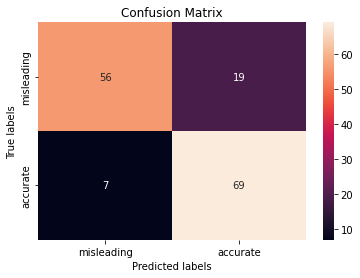

In [ ]:
X_test_headline = vectorizer.transform(news_dataset_test_cleaned["Headline"])
X_test_body = vectorizer.transform(news_dataset_test_cleaned["Body"])

# Testing the model on held-out test data
X_test_headline_body = np.concatenate((X_test_headline.toarray(), X_test_body.toarray()), axis=1)
pred_baseline = gb_clf_best.predict(X_test_headline_body)
true_baseline = y_test
from sklearn.metrics import classification_report
print(classification_report(true_baseline, pred_baseline))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true_baseline, pred_baseline, labels=[1,0]), annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true_baseline, pred_baseline), 2)}, F1 Score: {round(f1_score(true_baseline, pred_baseline), 2)}")

# Saving the Baseline model

In [ ]:
# Save the tf idf vectorizer
dump(vectorizer, '/content/drive/MyDrive/Datasets/gb_best_model/tf_tdf_vectorizer.joblib')
# Save the model
dump(gb_clf, '/content/drive/MyDrive/Datasets/gb_best_model/gb_clf.joblib')

['/content/drive/MyDrive/Datasets/gb_best_model/gb_clf.joblib']

# Recurrent neural network models (with Attention mechamism)

Before model building and training, some further pre-processing steps like Tokenization, Padding and Word vectors loading need to be done. This is almost a routine steps to be performed for any keras NLP task.

In [10]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="UNKNOWN")
tokenizer.fit_on_texts(
    news_dataset_train_cleaned["Headline"]+news_dataset_train_cleaned["Body"]
)

# Text to sequences
train_headline_sequences = tokenizer.texts_to_sequences(news_dataset_train_cleaned["Headline"])
train_body_sequences = tokenizer.texts_to_sequences(news_dataset_train_cleaned["Body"])

# Pad sequences
train_headline_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    train_headline_sequences, padding='post'
)

train_body_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    train_body_sequences, padding='post'
)
# Seperately getting target label
train_news_dataset_cleaned_label = y_train

In [11]:
# Load the fasttext model for Hindi language
# It can be downloaded from here https://fasttext.cc/docs/en/crawl-vectors.html
ft_hindi = fasttext.load_model('/content/drive/MyDrive/WordVecs/cc.hi.300.bin')
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 300
def create_embedding_matrix(vocab_size, embedding_dim, word_index, fasttext_model):
  embedding_matrix = np.zeros((vocab_size, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = fasttext_model.get_word_vector(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  return embedding_matrix    
embedding_matrix = create_embedding_matrix(vocab_size, embedding_dim, tokenizer.word_index, ft_hindi)  

# Modelling (Bi-LSTM + Dot Product Attention + FFNN)



In [12]:
# Creating an custom Attention layer
class CustomAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(CustomAttention, self).__init__()

  def call(self, inputs):
    headline_body_dot = tf.matmul(inputs[1], inputs[0], transpose_b=True) # (batch_size, T_headline, dim) . (batch_size, T_body, dim) = (batch_size, T_headline, T_body)
    attention_scores = tf.nn.softmax(headline_body_dot, axis=1) # (batch_size, T_headline, T_body)
    final_output = tf.matmul(attention_scores, inputs[0]) # (batch_size, T_headline, T_body) . (batch_size, T_body, dim) = (batch_size, T_headline, dim)
    concat = tf.concat([inputs[0], final_output], 1)
    return concat, attention_scores

headline_length = len(train_headline_sequences_padded[0])
body_length = len(train_body_sequences_padded[0])
embedding_dim = 300
input_headline = tf.keras.layers.Input(shape=(headline_length,), name="headline_input_layer")
embedding_headline = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero=True)(input_headline)

input_body = tf.keras.layers.Input(shape=(body_length,), name="body_input_layer")
embedding_body = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix], 
                                trainable = False,
                                mask_zero=True)(input_body)

headline_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="headline_lstm",
                                                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(embedding_headline)     
body_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="body_lstm",
                                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(embedding_body) 

headline_body_attention_seq, attention = CustomAttention()([body_lstm, headline_lstm])

x = tf.keras.layers.Flatten()(headline_body_attention_seq)
x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_with_dot_attn = tf.keras.Model([input_headline, input_body], [x])

model_with_dot_attn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

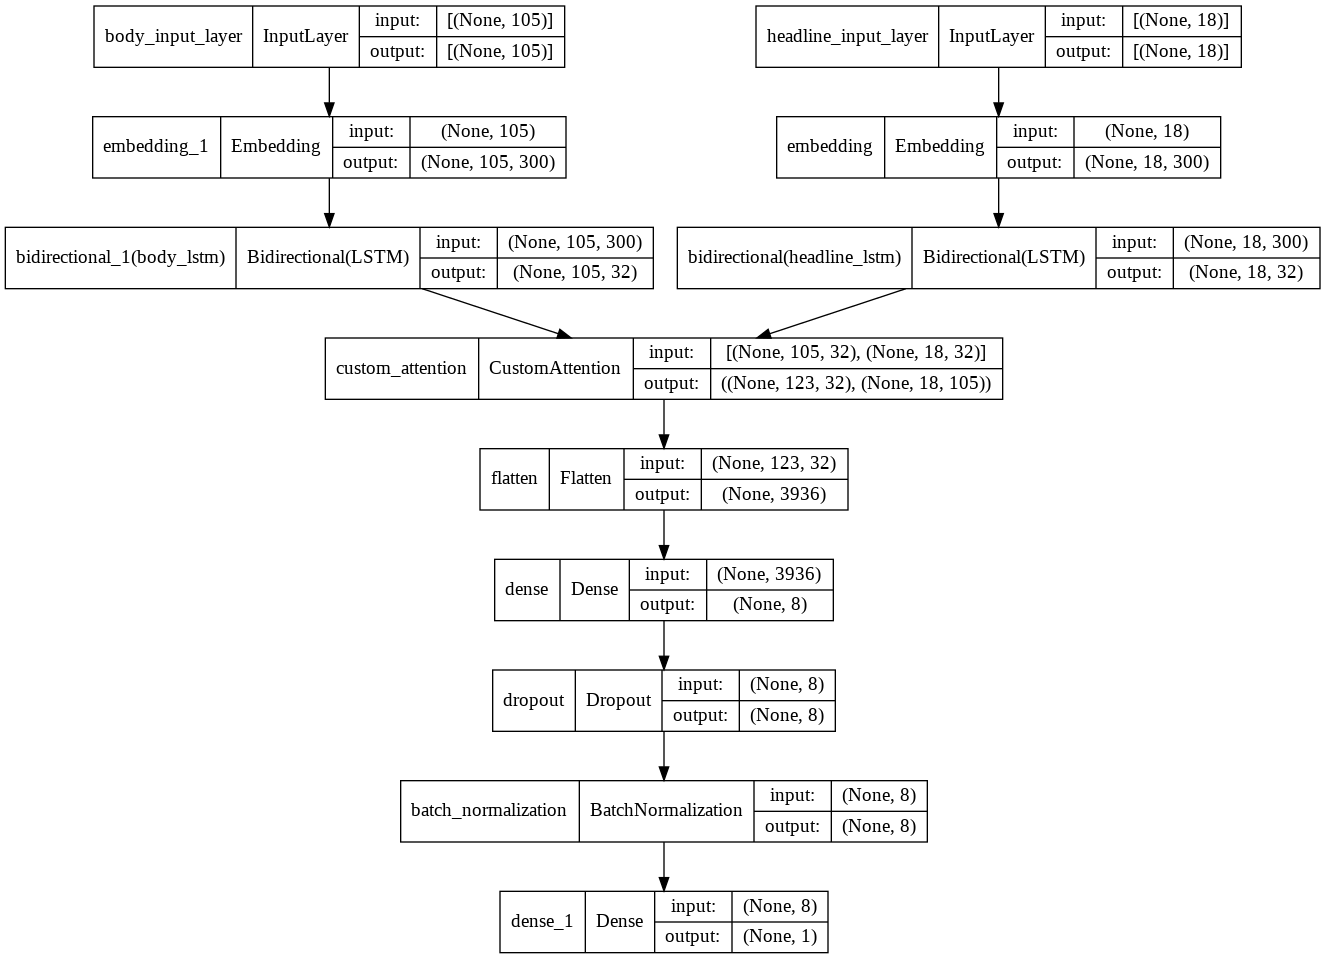

In [13]:
tf.keras.utils.plot_model(model_with_dot_attn, to_file="model_with_dot_attn.png", show_shapes=True)

In [14]:
num_epoch = 200
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model training
model_log_dot_attn = model_with_dot_attn.fit([train_headline_sequences_padded, train_body_sequences_padded], train_news_dataset_cleaned_label,
          epochs=num_epoch, verbose=1, batch_size=32, validation_split=0.2, callbacks=[es_callback])

Epoch 1/200
15/15 [==============================] - 22s 558ms/step - loss: 5.6790 - accuracy: 0.5292 - val_loss: 4.2061 - val_accuracy: 0.4667
Epoch 2/200
15/15 [==============================] - 1s 94ms/step - loss: 3.2420 - accuracy: 0.5583 - val_loss: 2.3632 - val_accuracy: 0.5750
Epoch 3/200
15/15 [==============================] - 1s 95ms/step - loss: 1.9177 - accuracy: 0.6396 - val_loss: 1.6126 - val_accuracy: 0.5500
Epoch 4/200
15/15 [==============================] - 1s 92ms/step - loss: 1.4094 - accuracy: 0.6187 - val_loss: 1.2281 - val_accuracy: 0.7667
Epoch 5/200
15/15 [==============================] - 1s 91ms/step - loss: 1.0730 - accuracy: 0.6979 - val_loss: 1.0568 - val_accuracy: 0.7917
Epoch 6/200
15/15 [==============================] - 1s 93ms/step - loss: 0.9855 - accuracy: 0.6562 - val_loss: 0.9855 - val_accuracy: 0.7833
Epoch 7/200
15/15 [==============================] - 1s 95ms/step - loss: 0.8748 - accuracy: 0.6854 - val_loss: 0.9290 - val_accuracy: 0.6500
Epoc

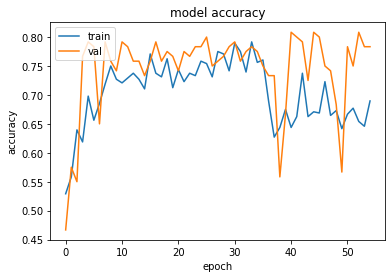

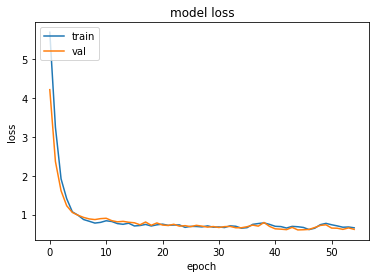

In [15]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(model_log_dot_attn.history['accuracy'])
plt.plot(model_log_dot_attn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_log_dot_attn.history['loss'])
plt.plot(model_log_dot_attn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
test_headline_sequences = tokenizer.texts_to_sequences(news_dataset_test_cleaned["Headline"])
test_body_sequences = tokenizer.texts_to_sequences(news_dataset_test_cleaned["Body"])
# padding test data to feed into network for prediction
test_headline_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    test_headline_sequences, padding='post', maxlen=train_headline_sequences_padded.shape[1]
)
test_body_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
    test_body_sequences, padding='post', maxlen=train_body_sequences_padded.shape[1]
)
# getting target label
test_news_dataset_cleaned_label = y_test

In [17]:
# Evaluating the model on held-out test data
model_with_dot_attn.evaluate([test_headline_sequences_padded, test_body_sequences_padded], test_news_dataset_cleaned_label)

5/5 [==============================] - 0s 28ms/step - loss: 0.6332 - accuracy: 0.7881


[0.6331872940063477, 0.7880794405937195]

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        80
           1       0.77      0.77      0.77        71

    accuracy                           0.79       151
   macro avg       0.79      0.79      0.79       151
weighted avg       0.79      0.79      0.79       151

Accuracy: 0.79, F1 Score: 0.77


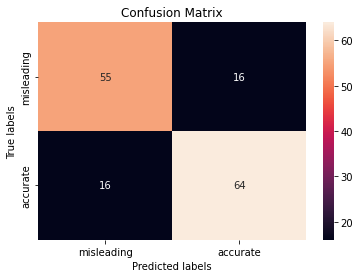

In [18]:
pred = model_with_dot_attn.predict([test_headline_sequences_padded, test_body_sequences_padded])
pred = np.array([0 if x < 0.5 else 1 for x in pred])
true = np.array(test_news_dataset_cleaned_label)
from sklearn.metrics import classification_report
print(classification_report(true, pred))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true, pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true, pred), 2)}, F1 Score: {round(f1_score(true, pred), 2)}")

# Saving the Bi-LSTM + Dot Product Attention + FFNN model

In [19]:
# Saving the model, tokenizer for future use
model_with_dot_attn.save("/content/drive/MyDrive/Datasets/nna_best_model")
with open('/content/drive/MyDrive/Datasets/nna_best_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_best_model/assets


# Modelling (Bi-LSTM + Additive Attention + FFNN)

In [58]:
headline_length = len(train_headline_sequences_padded[0])
body_length = len(train_body_sequences_padded[0])
embedding_dim = 300
input_headline = tf.keras.layers.Input(shape=(headline_length,), name="headline_input_layer")
embedding_headline = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero=True)(input_headline)

input_body = tf.keras.layers.Input(shape=(body_length,), name="body_input_layer")
embedding_body = tf.keras.layers.Embedding(input_dim = vocab_size, 
                                output_dim = embedding_dim,
                                weights = [embedding_matrix],
                                trainable = False,
                                mask_zero=True)(input_body)

headline_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="headline_lstm",
                                                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(embedding_headline)     
body_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="body_lstm",
                                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(embedding_body) 

headline_body_attention_seq = tf.keras.layers.AdditiveAttention(name="additive_attention_layer")([body_lstm, headline_lstm])

body_encoding = tf.keras.layers.GlobalAveragePooling1D()(body_lstm)
headline_body_attention = tf.keras.layers.GlobalAveragePooling1D()(headline_body_attention_seq)  

concat_layer = tf.keras.layers.Concatenate(axis=1)([body_encoding, headline_body_attention])

x = tf.keras.layers.Flatten()(concat_layer)
x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_with_add_attn = tf.keras.Model([input_headline, input_body], [x])

model_with_add_attn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

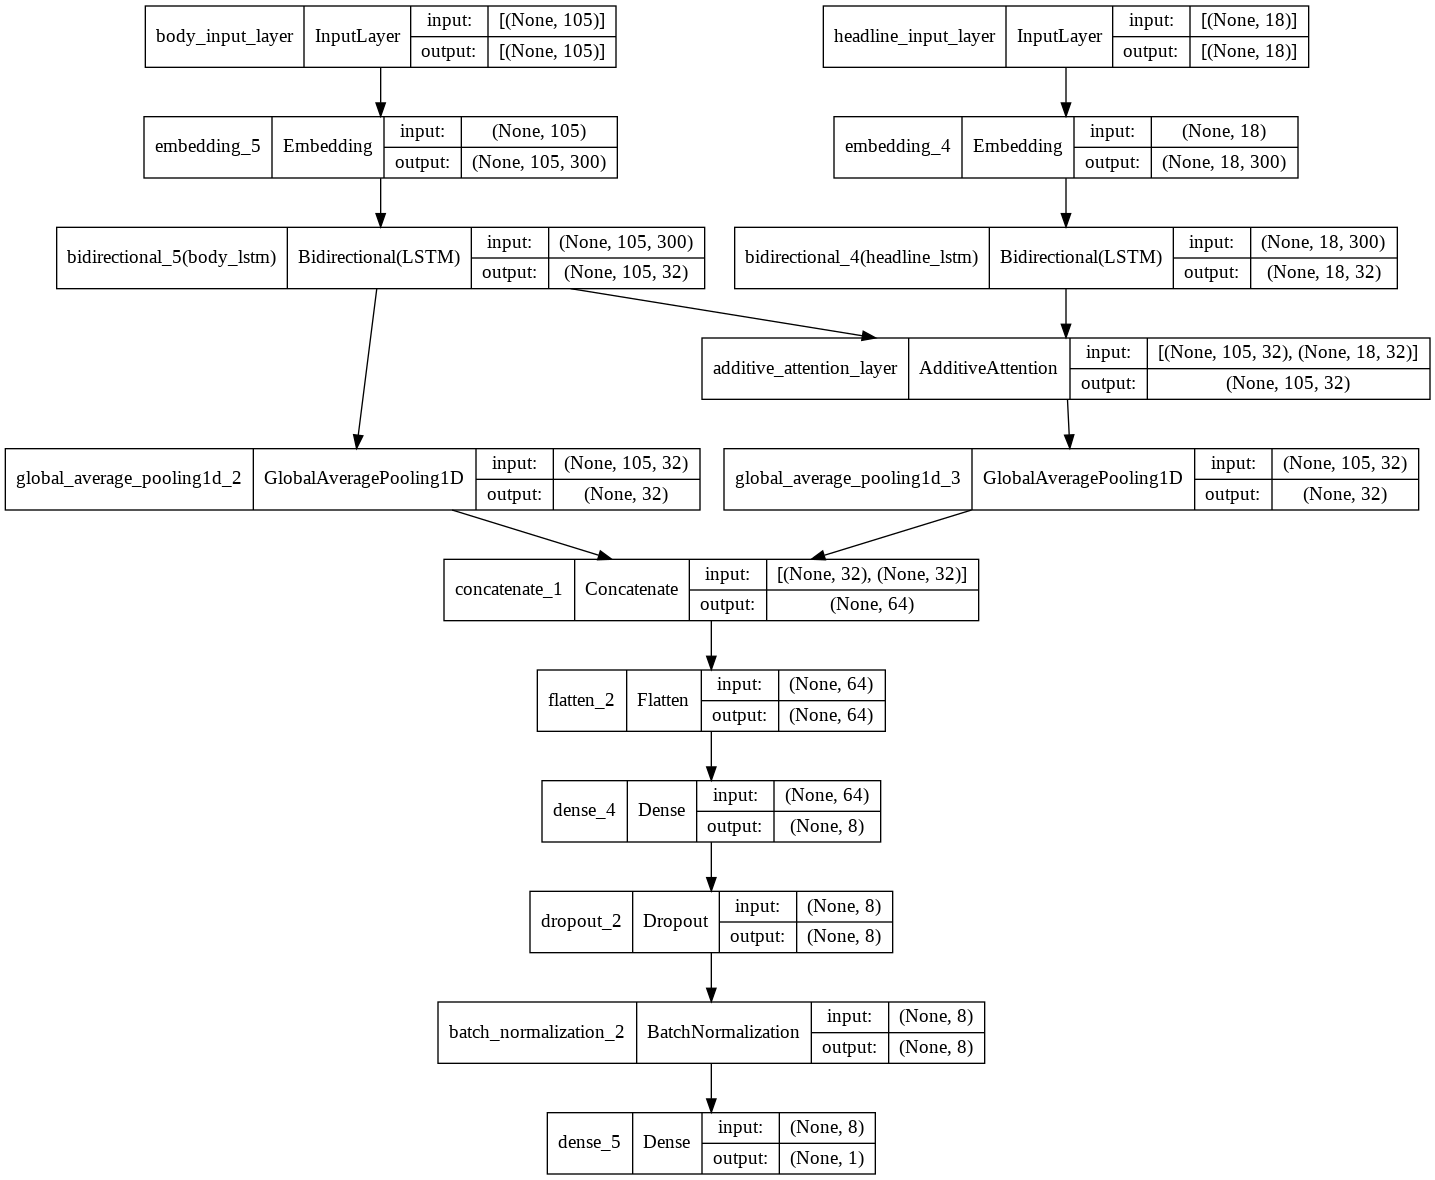

In [22]:
tf.keras.utils.plot_model(model_with_add_attn, to_file="model_with_add_attn.png", show_shapes=True)

In [59]:
num_epoch = 200
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model training
model_log_add_attn = model_with_add_attn.fit([train_headline_sequences_padded, train_body_sequences_padded], train_news_dataset_cleaned_label,
          epochs=num_epoch, verbose=1, batch_size=32, validation_split=0.2, callbacks=[es_callback])

Epoch 1/200
15/15 [==============================] - 23s 560ms/step - loss: 1.6177 - accuracy: 0.5312 - val_loss: 1.5518 - val_accuracy: 0.5583
Epoch 2/200
15/15 [==============================] - 2s 105ms/step - loss: 1.5244 - accuracy: 0.5479 - val_loss: 1.4917 - val_accuracy: 0.5583
Epoch 3/200
15/15 [==============================] - 2s 101ms/step - loss: 1.4603 - accuracy: 0.5437 - val_loss: 1.4327 - val_accuracy: 0.5583
Epoch 4/200
15/15 [==============================] - 2s 104ms/step - loss: 1.3955 - accuracy: 0.5333 - val_loss: 1.3753 - val_accuracy: 0.5583
Epoch 5/200
15/15 [==============================] - 2s 103ms/step - loss: 1.3380 - accuracy: 0.5583 - val_loss: 1.3184 - val_accuracy: 0.5583
Epoch 6/200
15/15 [==============================] - 2s 104ms/step - loss: 1.2786 - accuracy: 0.5708 - val_loss: 1.2631 - val_accuracy: 0.5583
Epoch 7/200
15/15 [==============================] - 2s 101ms/step - loss: 1.2098 - accuracy: 0.5792 - val_loss: 1.2097 - val_accuracy: 0.558

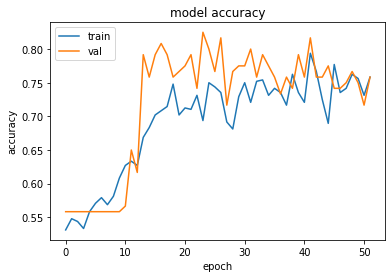

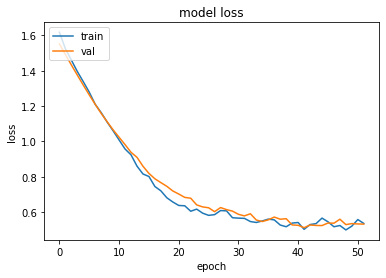

In [60]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(model_log_add_attn.history['accuracy'])
plt.plot(model_log_add_attn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_log_add_attn.history['loss'])
plt.plot(model_log_add_attn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
# Evaluating the model on held-out test data
model_with_add_attn.evaluate([test_headline_sequences_padded, test_body_sequences_padded], test_news_dataset_cleaned_label)

5/5 [==============================] - 0s 31ms/step - loss: 0.5633 - accuracy: 0.7417


[0.5633326768875122, 0.7417218685150146]

              precision    recall  f1-score   support

           0       0.73      0.82      0.77        80
           1       0.77      0.65      0.70        71

    accuracy                           0.74       151
   macro avg       0.75      0.74      0.74       151
weighted avg       0.74      0.74      0.74       151

Accuracy: 0.74, F1 Score: 0.7


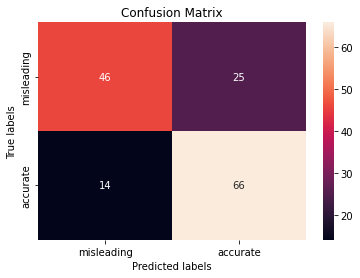

In [62]:
pred = model_with_add_attn.predict([test_headline_sequences_padded, test_body_sequences_padded])
pred = np.array([0 if x < 0.5 else 1 for x in pred])
true = np.array(test_news_dataset_cleaned_label)
from sklearn.metrics import classification_report
print(classification_report(true, pred))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true, pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true, pred), 2)}, F1 Score: {round(f1_score(true, pred), 2)}")

# Saving the Bi-LSTM + Additive Attention + FFNN model

In [64]:
# Saving the model, tokenizer for future use
model_with_add_attn.save("/content/drive/MyDrive/Datasets/nna_additive_attn_best_model")
with open('/content/drive/MyDrive/Datasets/nna_additive_attn_best_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_additive_attn_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_additive_attn_best_model/assets


# Modelling (BERT word embeddings + Bi-LSTM + Dot Product Attention + FFNN)

In [50]:
tokenizer_transformer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert') # please restart after installing sentencepiece library
model_transformer_orig = TFAutoModel.from_pretrained('ai4bharat/indic-bert', from_pt=True)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['sop_classifier.classifier.weight', 'predictions.decoder.weight', 'predictions.decoder.bias', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel

In [51]:
# Tokenize train sets
train_headline_tokens = tokenizer_transformer(list(news_dataset_train_cleaned["Headline"]), padding="longest", return_tensors="tf")
train_body_tokens = tokenizer_transformer(list(news_dataset_train_cleaned["Body"]), padding="longest", return_tensors="tf")

train_headline_embeddings = model_transformer_orig(**train_headline_tokens)
train_body_embeddings = model_transformer_orig(**train_body_tokens)

# Tokenize test sets
test_headline_tokens = tokenizer_transformer(list(news_dataset_test_cleaned["Headline"]), padding="max_length", max_length=train_headline_embeddings[0].shape[1], return_tensors="tf")
test_body_tokens = tokenizer_transformer(list(news_dataset_test_cleaned["Body"]), padding="max_length", max_length=train_body_embeddings[0].shape[1], return_tensors="tf")

test_headline_embeddings = model_transformer_orig(**test_headline_tokens)
test_body_embeddings = model_transformer_orig(**test_body_tokens)

In [52]:
headline_length = train_headline_embeddings[0].shape[1]
body_length = train_body_embeddings[0].shape[1]
embedding_dim = 768

input_headline = tf.keras.layers.Input(shape=(headline_length, embedding_dim,))
input_body = tf.keras.layers.Input(shape=(body_length, embedding_dim,))

headline_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="headline_lstm", 
                                                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(input_headline)     
body_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, dropout=0.7, name="body_lstm", 
                                                                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5)))(input_body) 

headline_body_attention_seq = tf.keras.layers.Attention(dropout=0.7)([body_lstm, headline_lstm])

body_encoding = tf.keras.layers.GlobalAveragePooling1D()(body_lstm)
body_headline_attention = tf.keras.layers.GlobalAveragePooling1D()(headline_body_attention_seq)  

concat_layer = tf.keras.layers.Concatenate(axis=1)([body_encoding, body_headline_attention])

x = tf.keras.layers.Flatten()(concat_layer)
x = tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2())(x)
x = tf.keras.layers.Dropout(0.7)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_transformer = tf.keras.Model([input_headline, input_body], [x])

model_transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

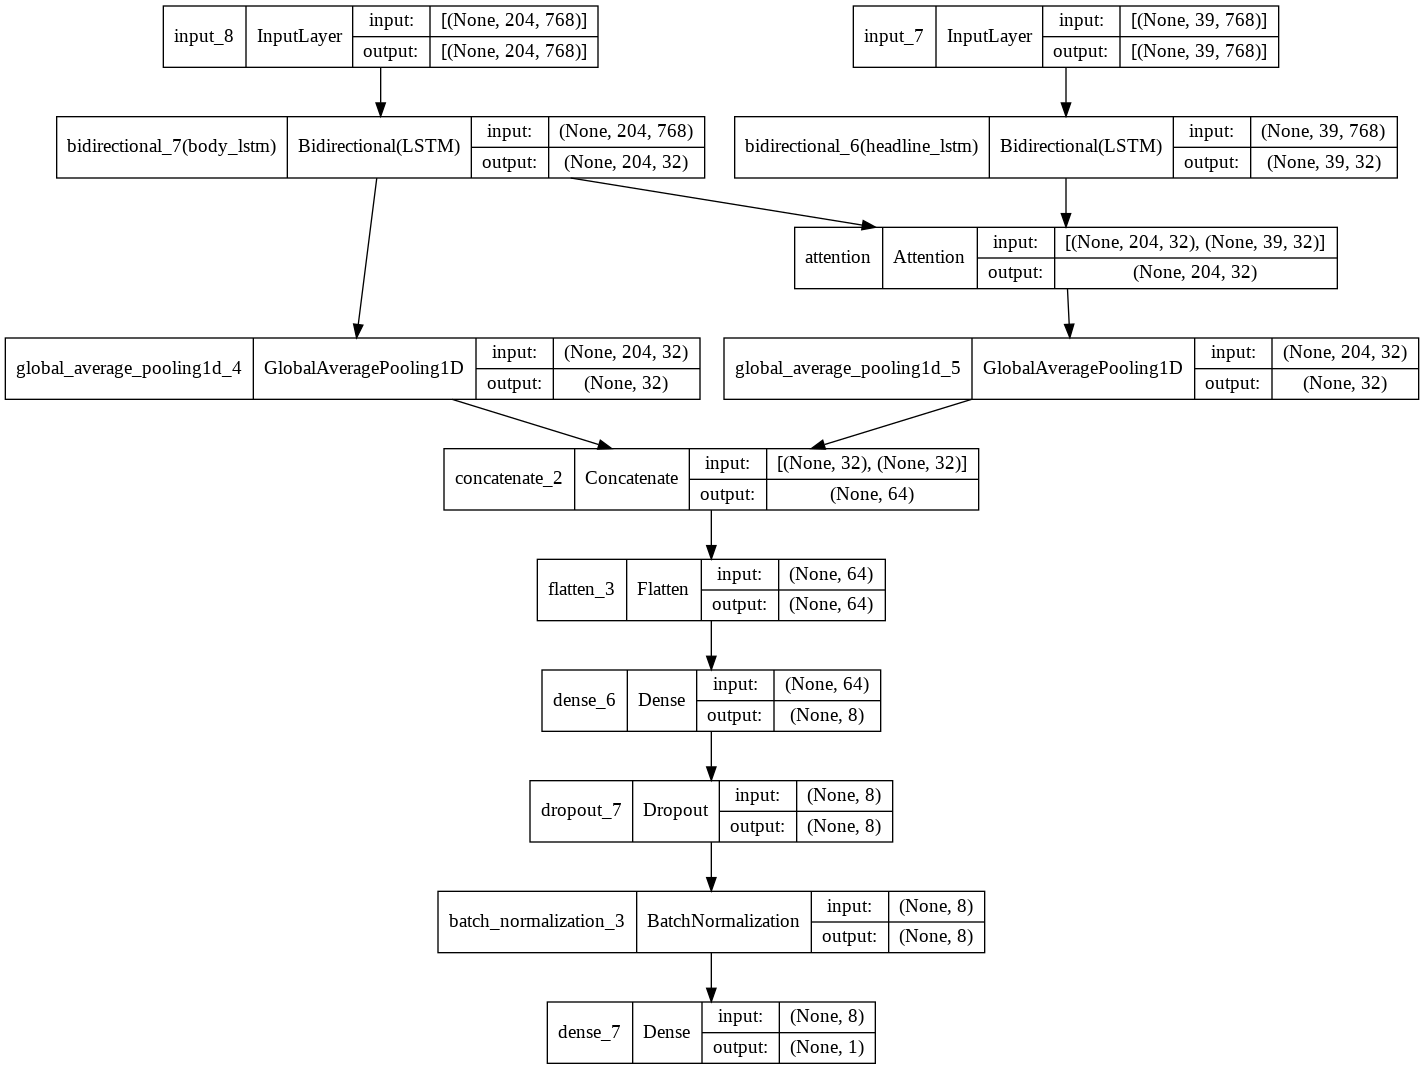

In [53]:
tf.keras.utils.plot_model(model_transformer, to_file="model_transformer.png", show_shapes=True)

In [ ]:
num_epoch = 100
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
#model training
model_transformer_log = model_transformer.fit([train_headline_embeddings[0], train_body_embeddings[0]], y_train,
          epochs=num_epoch, verbose=1, batch_size=32, validation_split=0.2)#, callbacks=[es_callback])

Epoch 1/100
15/15 [==============================] - 11s 277ms/step - loss: 1.6769 - accuracy: 0.5250 - val_loss: 1.5859 - val_accuracy: 0.4833
Epoch 2/100
15/15 [==============================] - 3s 170ms/step - loss: 1.5795 - accuracy: 0.5542 - val_loss: 1.4721 - val_accuracy: 0.6333
Epoch 3/100
15/15 [==============================] - 2s 168ms/step - loss: 1.4860 - accuracy: 0.5458 - val_loss: 1.4406 - val_accuracy: 0.5750
Epoch 4/100
15/15 [==============================] - 3s 171ms/step - loss: 1.4164 - accuracy: 0.5667 - val_loss: 1.4019 - val_accuracy: 0.5167
Epoch 5/100
15/15 [==============================] - 3s 168ms/step - loss: 1.3746 - accuracy: 0.5500 - val_loss: 1.3586 - val_accuracy: 0.5167
Epoch 6/100
15/15 [==============================] - 2s 168ms/step - loss: 1.3239 - accuracy: 0.5688 - val_loss: 1.3144 - val_accuracy: 0.5167
Epoch 7/100
15/15 [==============================] - 3s 170ms/step - loss: 1.2855 - accuracy: 0.5458 - val_loss: 1.2722 - val_accuracy: 0.525

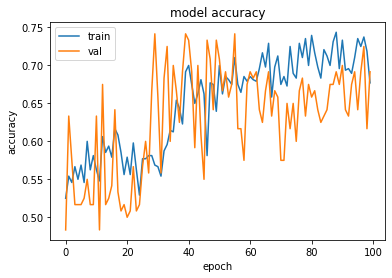

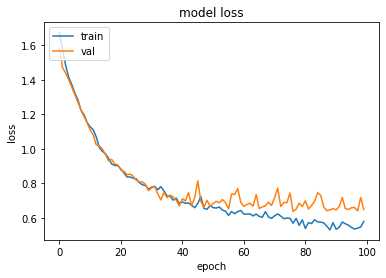

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(model_transformer_log.history['accuracy'])
plt.plot(model_transformer_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_transformer_log.history['loss'])
plt.plot(model_transformer_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluating the model on held-out test data
model_transformer.evaluate([test_headline_embeddings[0], test_body_embeddings[0]], y_test)

5/5 [==============================] - 0s 53ms/step - loss: 0.6299 - accuracy: 0.7020


[0.6298633813858032, 0.7019867300987244]

              precision    recall  f1-score   support

           0       0.73      0.63      0.68        75
           1       0.68      0.78      0.72        76

    accuracy                           0.70       151
   macro avg       0.71      0.70      0.70       151
weighted avg       0.71      0.70      0.70       151

Accuracy: 0.7, F1 Score: 0.72


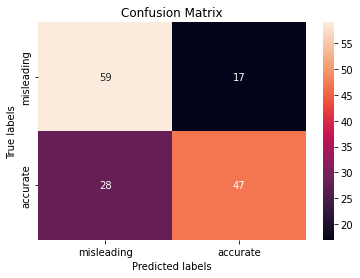

In [ ]:
pred = model_transformer.predict([test_headline_embeddings[0], test_body_embeddings[0]])
pred = np.array([0 if x < 0.5 else 1 for x in pred])
true = np.array(y_test)
from sklearn.metrics import classification_report
print(classification_report(true, pred))

import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix   

ax = plt.subplot()
sns.heatmap(confusion_matrix(true, pred, labels=[1,0]), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['misleading', 'accurate']); ax.yaxis.set_ticklabels(['misleading', 'accurate']);

print(f"Accuracy: {round(accuracy_score(true, pred), 2)}, F1 Score: {round(f1_score(true, pred), 2)}")

# Saving the BERT word embeddings + Bi-LSTM + Dot Product Attention + FFNN model

In [ ]:
# Saving the model, tokenizer for future use
model_transformer.save("/content/drive/MyDrive/Datasets/nna_transformer_best_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_transformer_best_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets/nna_transformer_best_model/assets


# Model Comparison

This is just a rough comparison of scores each model has after limited hyperparameter tuning. I am sure slight improvements can be made with a bit more aggressive tuning.

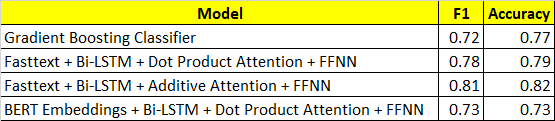

# Experiments

Making predictions on an actual online news articles. 

The model outputs probability of a headline being misleading (due to misuse of superlatives) given each of the paragraphs constituting its body. A probability of less than 0.5 means the superlatives used in the headlines is not misleading and the corresponding paragraph justifies the superlative, as a result the headline-paragraph pair is marked green. For anything higher than that, it gets marked red.

In [3]:
# Load the saved model with best overall accuracy and F1 Score
model_nn = keras.models.load_model('/content/drive/MyDrive/Datasets/nna_additive_attn_best_model')
with open('/content/drive/MyDrive/Datasets/nna_additive_attn_best_model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
model_nn.get_layer("headline_input_layer").output.shape[1]

18

In [7]:
model_nn.get_layer("body_input_layer").output.shape[1]

105

In [9]:
def text_cleanup(body_text):
  """Performs all the text pre-processing steps

        Args
        ----------
        body_text : string
            text to be pre-processed

        Returns
        ----------
        pre-processed text
  """
  body_text = remove_english_words(body_text)
  body_text = remove_line_feeds(body_text)
  #body_text = replace_numbers(body_text)
  #body_text = replace_percent(body_text)
  body_text = remove_english_words(body_text)
  body_text = remove_punctuations(body_text)
  body_text = remove_string_numbers(body_text)
  body_text = remove_numbers(body_text)
  body_text = remove_unwanted_chars(body_text)
  body_text = remove_stopwords(body_text)
  body_text = remove_extra_spaces(body_text)
  body_text = remove_leading_trailing_spaces(body_text)
  return body_text

def predict_and_render(url, model_type, model_name, tokenizer_vectorizer):
  """Reads content from an url, identifies headlines and paragraphs, classifies each headline-para pair as misleading or accurate and then color codes them,
     This code currently only supports predictions using fasText embeddings or tf-idf vectorizer as features

        Args
        ----------
        url : string
            url of a news article
        model_type : string
            type of model being passed, currently nna (for keras model) and gb (for sklearn gradient boosting classifier) are supported
        model_name : saved model (h5, joblib, pickle etc.)
            saved model file
        tokenizer_vectorizer : saved tokenizer/vectorizer (joblib, pickle etc.)
            tokenizer or vectorizer for feature transformation

        Returns
        ----------
        None
  """
  misleading = "red"  
  try:
      content = BeautifulSoup(requests.get(url).content, "html.parser")
  except:
      content = None
  if content:
      heading = content.find("h1")
      bodies = content.findAll(['p', 'h2', 'h3', 'h4', 'h5', 'h6'])
      for body in bodies:
        # Identify headline
        if len(body.text.strip().split()) > 15:
          # Pre-processing
          cleaned_body = text_cleanup(body.text)
          cleaned_headline = text_cleanup(heading.text)
          if model_type == "nna":
            # Feature transformation and predictions
            pred_headline_sequences = tokenizer_vectorizer.texts_to_sequences([cleaned_headline])
            pred_headline_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
                        pred_headline_sequences, padding='post', maxlen=model_name.get_layer("headline_input_layer").output.shape[1]
                        )
            pred_body_sequences = tokenizer_vectorizer.texts_to_sequences([cleaned_body])
            pred_body_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(
                pred_body_sequences, padding='post', maxlen=model_name.get_layer("body_input_layer").output.shape[1]
                )
            pred = model_name.predict([pred_headline_sequences_padded, pred_body_sequences_padded])
            # Color coding the paragraphs based on preductions
            if 0 <= pred[0][0] < 0.5:
              body.attrs['style'] = "background-color: #6BA515"  
              misleading = "green"
            else:
              body.attrs['style'] = "background-color: #FF0000"
              if misleading != "green":
                misleading = "red"
          if model_type == "gb":    
            X_headline = tokenizer_vectorizer.transform([cleaned_headline])
            X_body = tokenizer_vectorizer.transform([cleaned_body])
            X_headline_body = np.concatenate((X_headline.toarray(), X_body.toarray()), axis=1)
            pred = model_name.predict_proba(X_headline_body)
            if 0 <= pred[0] < 0.5:
              body.attrs['style'] = "background-color: #6BA515"  
              misleading = "green"
            else:
              body.attrs['style'] = "background-color: #FF0000" 
              if misleading != "green":
                misleading = "red"
  #  Color coding the headline based on whether at least one or no justified paragraph was found              
  if misleading == "green":
    heading.attrs['style'] = "background-color: #6BA515"    
  else:
    heading.attrs['style'] = "background-color: #FF0000"        
  from IPython.core.display import HTML
  # Display the color coded article
  display(HTML(str(content))) 

In [ ]:
# Predicting on some real news articles
predict_and_render("https://nedricknews.com/business/petrol-diesel-rate-in-different-states-on-friday-5th-november-w57ws", "nna", model_nn)

In [ ]:
predict_and_render("https://www.msn.com/hi-in/money/topstories/%E0%A4%B0-%E0%A4%B9%E0%A4%A4-%E0%A4%AD%E0%A4%B0-42%E0%A4%B5-%E0%A4%A6-%E0%A4%A8-%E0%A4%AA%E0%A5%87%E0%A4%9F%E0%A5%8D%E0%A4%B0-%E0%A4%B2-%E0%A4%A1-%E0%A4%9C%E0%A4%B2-%E0%A4%95%E0%A5%87-%E0%A4%A8%E0%A4%8F-%E0%A4%B0%E0%A5%87%E0%A4%9F-%E0%A4%9C-%E0%A4%B0-%E0%A4%87%E0%A4%B8-%E0%A4%B6%E0%A4%B9%E0%A4%B0-%E0%A4%AE%E0%A5%87%E0%A4%82-%E0%A4%B8%E0%A4%AC%E0%A4%B8%E0%A5%87-%E0%A4%AE%E0%A4%B9%E0%A4%82%E0%A4%97/ar-AARRovA?li=AAuuIpA", "nna", model_nn)

शहर,पेट्रोल (रुपये/लीटर),डीज़ल (रुपये/लीटर)
श्रीगंगानगर,112.11,95.26
पोर्ट ब्लेयर,82.96,77.13
जयपुर,107.06,90.70
दिल्ली,95.41,86.67
मुंबई,109.98,94.14
चेन्नई,101.4,91.43
कोलकाता,104.67,89.79
भोपाल,107.23,90.87
रांची,98.52,91.56
बेंगलुरु,100.58,85.01


In [ ]:
predict_and_render("https://www.newsnationtv.com/entertainment/bollywood/manuhi-chhillar-reveal-why-november-i-her-luckiet-month-226865.html", "nna", model_nn)

In [ ]:
predict_and_render("https://hindi.news18.com/news/ajab-gajab/viral-agarwood-most-rare-and-most-expensive-wood-costly-than-diamond-and-gold-ashas-3768261.html", "nna", model_nn)

In [ ]:
predict_and_render("https://bollywoodoffice.com/religion-know-which-of-the-4-zodiac-signs-are-the-most-fortunate/", "nna", model_nn)